In [1]:
# For operating system interaction
import os
import glob
import datetime
import sys

# For loading .pkl files.
import pickle

# For scientific computing
import numpy as np
import pandas as pd
import scipy.special
import statsmodels.tools.numdiff as smnd # to compute the Hessian matrix

# Library to perform MCMC sampling
import emcee

# Import custom utilities
import mwc_induction_utils as mwc

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
mwc.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_format = 'svg'

In [8]:
def y_ratio(e_ai, ei_ea, n=2):
    '''
    Computes the ratio of saturation to leakiness as defined by Daber and
    Lewis.
    Parameters
    ----------
    e_ai : array-like.
        Energy difference between the active and inactive conformation of 
        the repressor
    ei_ea : array-like/
        Originally the ratio Ka/Ki transformed into binding energies to work
        in log scale.
    '''
    return (1 + np.exp(-e_ai)) / (1 + np.exp(-e_ai) * np.exp(-n * ei_ea))

In [61]:
def log_post(param, saturation, leakiness, n=2):
    '''
    Computes the log posterior of the two parameters e_ai and ei_ea assuming
    a Gaussian likelihood and uniform priors for both parameters given the 
    experimentally determined values of leakiness and saturation.
    Parameters
    ----------
    param : array-like.
        Array containing both parameters:
        param[0] = e_ai
        param[1] = ei_ea
    saturation, leakiness: array-like.
        Experimental values of the saturation and leakiness in fold-change.
    '''
    # Unpack parameters
    e_ai = param[0]
    ei_ea = param[1]
    
    # Compute the quantity used by Daber and Lewis to fit the parameters
    y_saturation = 1 / saturation - 1
    y_leakiness = 1 / leakiness - 1
    y_ratio_exp = y_saturation / y_leakiness
    
    # Compute the theoretical y_ratio
    y_ratio_thry = y_ratio(e_ai, ei_ea, n)
    
    # return the log posterior
    return -np.size(saturation) / 2 * \
           np.log(np.sum((y_ratio_exp - y_ratio_thry)**2))

## Testing the function with real data

In [62]:
datadir = '../../data/'
# read the list of data-sets to ignore
df = pd.read_csv(datadir + 'flow_master.csv', comment='#')

# Now we remove the autofluorescence and delta values
df = df[(df.rbs != 'auto') & (df.rbs != 'delta')]

df.head()

,date,username,operator,binding_energy,rbs,repressors,IPTG_uM,mean_YFP_A,mean_YFP_bgcorr_A,fold_change_A
2,20160804,mrazomej,O2,-13.9,RBS1L,870,0.0,3624.474605,111.851286,0.007146
3,20160804,mrazomej,O2,-13.9,RBS1,610,0.0,3619.786265,107.162946,0.006847
4,20160804,mrazomej,O2,-13.9,RBS1027,130,0.0,3717.019527,204.396208,0.013059
5,20160804,mrazomej,O2,-13.9,RBS446,62,0.0,3854.650585,342.027265,0.021853
6,20160804,mrazomej,O2,-13.9,RBS1147,30,0.0,4169.802851,657.179531,0.041988


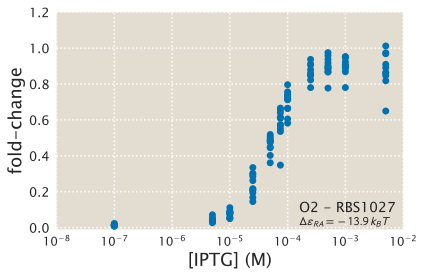

In [63]:
rbs = df[(df.rbs=='RBS1027') & (df.binding_energy==-13.9)]

fig, ax = plt.subplots(1, 1)

ax.plot(rbs.IPTG_uM / 1E6,
         rbs.fold_change_A, 'o',
         alpha=0.7)
ax.set_xscale('log')
ax.set_xlabel('[IPTG] (M)')
ax.set_ylabel('fold-change')
ax.set_xlim([1E-8, 1E-2])
ax.set_ylim([-0.01, 1.2])
# Add operator and binding energy labels.
ax.text(0.7, 0.08, r'{0}'.format('O2 - RBS1027'), transform=ax.transAxes, 
        fontsize=14)
ax.text(0.7, 0.02,
        r'$\Delta\varepsilon_{RA} = %s\,k_BT$' %-13.9,
        transform=ax.transAxes, fontsize=12)

plt.tight_layout()

In [159]:
rbs.head()

,date,username,operator,binding_energy,rbs,repressors,IPTG_uM,mean_YFP_A,mean_YFP_bgcorr_A,fold_change_A
4,20160804,mrazomej,O2,-13.9,RBS1027,130,0.0,3717.019527,204.396208,0.013059
12,20160804,mrazomej,O2,-13.9,RBS1027,130,0.1,3666.908863,148.489234,0.008699
20,20160804,mrazomej,O2,-13.9,RBS1027,130,5.0,4240.010601,800.582704,0.045769
28,20160804,mrazomej,O2,-13.9,RBS1027,130,10.0,5366.244059,1951.434974,0.111151
36,20160804,mrazomej,O2,-13.9,RBS1027,130,25.0,9264.452797,5909.675420,0.334437


In [64]:
saturation = []
leakiness = []
rbs_group = rbs.groupby(['date', 'username'])
for group, data in rbs_group:
    if data.IPTG_uM.max() == 5000.0:
        saturation.append(data[data.IPTG_uM == data.IPTG_uM.max()].\
                          fold_change_A.values[0])
        leakiness.append(data[data.IPTG_uM == data.IPTG_uM.min()].\
                         fold_change_A.values[0])

saturation = np.array(saturation)
leakiness = np.array(leakiness)

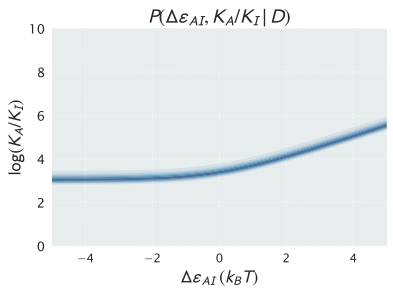

In [66]:
# Parameter values to plot
e_ai = np.linspace(-5, 5, 150)
ei_ea = np.linspace(-10, -0, 150)

# make a grid to plot
eai_grid, ei_ea_grid = np.meshgrid(e_ai, ei_ea)

# compute the log posterior
log_posterior = np.empty_like(eai_grid)
for i in range(len(e_ai)):
    for j in range(len(ei_ea)):
        log_posterior[i, j] = log_post([eai_grid[i, j], ei_ea_grid[i, j]],\
                                       saturation, leakiness, 2)

# Get things to scale better
log_posterior -= log_posterior.max()

# # plot the results
plt.figure()
plt.contourf(eai_grid, (-ei_ea_grid), np.exp(log_posterior), alpha=0.7,
             cmap=plt.cm.Blues)
plt.xlabel(r'$\Delta\varepsilon_{AI}\; (k_BT)$')
# plt.ylabel(r'$\Delta\varepsilon_I - \Delta\varepsilon_A$')
plt.ylabel(r'$\log (K_A / K_I)$')
plt.title('$P(\Delta\epsilon_{AI}, K_A/K_I \mid D)$')

# Testing Daber & Lewis data

In [18]:
df_daber = pd.read_csv(datadir + 'Daber_Lewis_OneIsNotEnough.csv')
df_daber.head()

,data_set,IPTG_mM,fold_change
0,tetramer,0.000100,0.031737
1,tetramer,0.000500,0.037126
2,tetramer,0.001000,0.040719
3,tetramer,0.004910,0.143114
4,tetramer,0.009815,0.319162


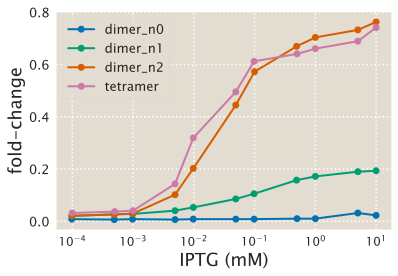

In [20]:
# Group by type of data set
df_group = df_daber.groupby('data_set')

for group, data in df_group:
    plt.plot(data.IPTG_mM, data.fold_change, marker='o',
            label=group)
plt.xscale('log')
plt.xlabel('IPTG (mM)')
plt.ylabel('fold-change')
plt.legend(loc=0)

In [46]:
def log_post_daber(param, n2, n1):
    '''
    Computes the log posterior of the two parameters e_ai and ei_ea assuming
    a Gaussian likelihood and uniform priors for both parameters given the 
    experimentally determined values of leakiness and saturation.
    Parameters
    ----------
    param : array-like.
        Array containing both parameters:
        param[0] = e_ai
        param[1] = ei_ea
    n2 : array-like. 2 entries
        n2[0] = saturation for dimer with 2 active binding sites
        n2[1] = leakiness for dimer with 2 active binding sites
    n1 : array-like. 2 entries
        n1[0] = saturation for dimer with 1 active binding sites
        n1[1] = leakiness for dimer with 1 active binding sites
    '''
    # Unpack parameters
    e_ai = param[0]
    ei_ea = param[1]
    
    # Compute parameters for n = 2 active binding sites
    y_saturation = 1 / n2[0] - 1
    y_leakiness = 1 / n2[1] - 1
    y_ratio_exp_n2 = y_saturation / y_leakiness
    
    # Compute the theoretical y_ratio
    y_ratio_thry_n2 = y_ratio(e_ai, ei_ea, 2)
    
    # Compute parameters for n = 2 active binding sites
    y_saturation = 1 / n1[0] - 1
    y_leakiness = 1 / n1[1] - 1
    y_ratio_exp_n1 = y_saturation / y_leakiness
    
    # Compute the theoretical y_ratio
    y_ratio_thry_n1 = y_ratio(e_ai, ei_ea, 1)
    
    y_ratio_exp = np.array([y_ratio_exp_n2, y_ratio_exp_n1])
    y_ratio_thry = np.array([y_ratio_thry_n2, y_ratio_thry_n1])
    
    # return the log posterior
    return -np.size(saturation) / 2 * \
           np.log(np.sum((y_ratio_exp - y_ratio_thry)**2))

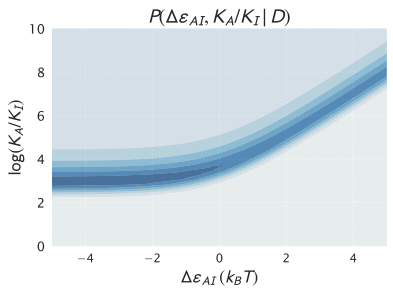

In [57]:
# Parameter values to plot
e_ai = np.linspace(-5, 5, 50)
ei_ea = np.linspace(-10, 0, 50)

# make a grid to plot
eai_grid, ei_ea_grid = np.meshgrid(e_ai, ei_ea)

df_n2 = df_daber[df_daber.data_set == 'dimer_n2']
df_n1 = df_daber[df_daber.data_set == 'dimer_n1']
n2 = np.array([df_n2[df_n2.IPTG_mM == df_n2.IPTG_mM.max()].fold_change.values,\
      df_n2[df_n2.IPTG_mM == df_n2.IPTG_mM.min()].fold_change.values])
n1 = np.array([df_n1[df_n1.IPTG_mM == df_n1.IPTG_mM.max()].fold_change.values,\
      df_n1[df_n1.IPTG_mM == df_n1.IPTG_mM.min()].fold_change.values])

# compute the log posterior
log_posterior = np.empty_like(eai_grid)
for i in range(len(e_ai)):
    for j in range(len(ei_ea)):
        log_posterior[i, j] = \
        log_post_daber([eai_grid[i, j], ei_ea_grid[i, j]], n2, n1)
                       

# Get things to scale better
log_posterior -= log_posterior.max()

# # plot the results
plt.figure()
plt.contourf(eai_grid, (-ei_ea_grid), np.exp(log_posterior), alpha=0.7,
             cmap=plt.cm.Blues)
plt.xlabel(r'$\Delta\varepsilon_{AI}\; (k_BT)$')
# plt.ylabel(r'$\Delta\varepsilon_I - \Delta\varepsilon_A$')
plt.ylabel(r'$\log (K_A / K_I)$')
plt.title('$P(\Delta\epsilon_{AI}, K_A/K_I \mid D)$')

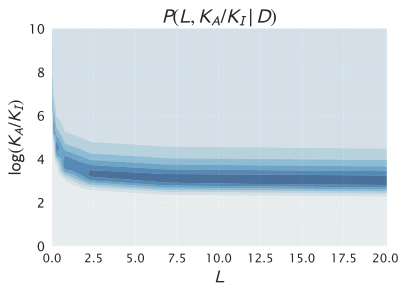

In [60]:
# Parameter values to plot
e_ai = np.linspace(-3, 50)
ei_ea = np.linspace(-10, 0, 50)

# make a grid to plot
eai_grid, ei_ea_grid = np.meshgrid(e_ai, ei_ea)

df_n2 = df_daber[df_daber.data_set == 'dimer_n2']
df_n1 = df_daber[df_daber.data_set == 'dimer_n1']
n2 = np.array([df_n2[df_n2.IPTG_mM == df_n2.IPTG_mM.max()].fold_change.values,\
      df_n2[df_n2.IPTG_mM == df_n2.IPTG_mM.min()].fold_change.values])
n1 = np.array([df_n1[df_n1.IPTG_mM == df_n1.IPTG_mM.max()].fold_change.values,\
      df_n1[df_n1.IPTG_mM == df_n1.IPTG_mM.min()].fold_change.values])

# compute the log posterior
log_posterior = np.empty_like(eai_grid)
for i in range(len(e_ai)):
    for j in range(len(ei_ea)):
        log_posterior[i, j] = \
        log_post_daber([eai_grid[i, j], ei_ea_grid[i, j]], n2, n1)
                       

# Get things to scale better
log_posterior -= log_posterior.max()

# # plot the results
plt.figure()
plt.contourf(np.exp(-eai_grid), (-ei_ea_grid), 
             np.exp(log_posterior), alpha=0.7,
             cmap=plt.cm.Blues)
plt.xlabel(r'$L$')
# plt.ylabel(r'$\Delta\varepsilon_I - \Delta\varepsilon_A$')
plt.ylabel(r'$\log (K_A / K_I)$')
plt.title('$P(L, K_A/K_I \mid D)$')